### Reverse-engineering of the PALEOMAP paleotopography images

- The starting point is Scotese's sequence of jpg images 
- Key decision is the choice of RGB ranges to use to segment the image into different height ranges
- Using these ranges, we isolate segments of the image in these ranges - with gaps in between, which are filled by interpolation
- The height value (in meters) assigned to each colour range is user-defined and possibly arbitrary for some areas (e.g. how high is an upland), but paleoshoreline should be preserved



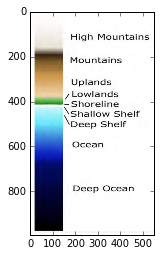

In [1]:
## 1. import modules, and also plot the color bar from the PALEOMAP docs

import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import inpaint
import os,glob

%matplotlib inline

SC = imread('/Users/Simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/image2grid/ColorScale.png')

plt.imshow(SC)


In [2]:
### The most important section - assign RGB ranges to be isolated and mapped to height values

# NB convention here is Red_min,Red_max,Green_min,Green_max,Blue_min,Blue_Max,Height
ColorMapping = np.array([[55,132,45,95,20,40,3000],  #  Dark Brown, Mountains
    [210,230,160,210,80,185,1500],     #  Brown, Uplands
    [75,110,140,190,70,90,1000],      # Mid Green, lowlands
    [70,90,100,120,70,90,500],        # Dark Green, just above shoreline
    [110,170,200,245,200,255,-500],   # Light Blue, shelf
    [0,30,35,55,65,85,-1500]])        # Deep Ocean



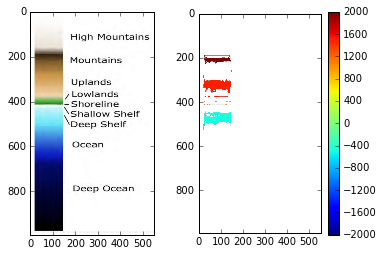

In [3]:
#### NOTE - THIS DOESN'T REALLY WORK THAT WELL
#### BECAUSE:
#### The colorscale from the documentation doesn't seem to match the actual images
#### that well in terms of exact RGB values. So, better to look at the RGB values in
#### some of the maps directly and infer heights from there

tmp = np.zeros(SC[:,:,0].shape)*np.nan

for j in np.arange(0,np.size(ColorMapping,0)):
    
    ind = (np.greater(SC[:,:,0],ColorMapping[j,0]) 
    & np.less(SC[:,:,0],ColorMapping[j,1])
    & np.greater(SC[:,:,1],ColorMapping[j,2])
    & np.less(SC[:,:,1],ColorMapping[j,3])
    & np.greater(SC[:,:,2],ColorMapping[j,4])
    & np.less(SC[:,:,2],ColorMapping[j,5]))
    
    tmp[ind] = ColorMapping[j,6]
    

plt.subplot(121)
plt.imshow(SC)
plt.subplot(122)
plt.imshow(tmp,vmin=-2000,vmax=2000)
plt.colorbar()


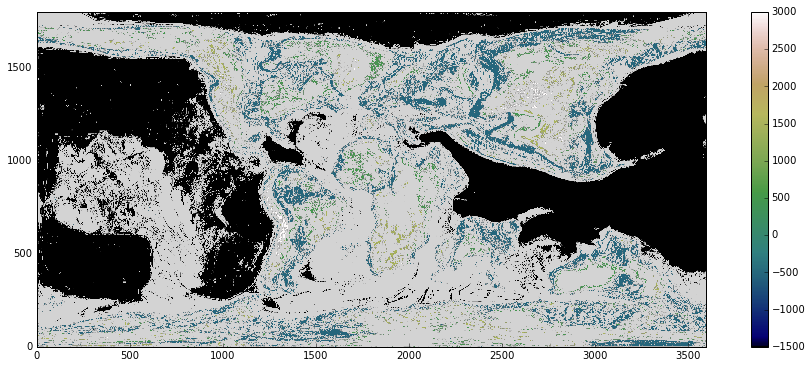

In [4]:
def image2grid(filename,ColorMapping):
    
    A = imread(filename)

    A = np.flipud(A)
    tmp = np.zeros(A[:,:,0].shape)*np.nan

    for j in np.arange(0,np.size(ColorMapping,0)):

        ind = (np.greater(A[:,:,0],ColorMapping[j,0]) 
        & np.less(A[:,:,0],ColorMapping[j,1])
        & np.greater(A[:,:,1],ColorMapping[j,2])
        & np.less(A[:,:,1],ColorMapping[j,3])
        & np.greater(A[:,:,2],ColorMapping[j,4])
        & np.less(A[:,:,2],ColorMapping[j,5]))

        tmp[ind] = ColorMapping[j,6]

    return tmp,A


filen = '/Users/Simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/PALEOMAP_PaleoAtlas_Rasters/Map20 LtK Santonian-Coniacian_085.jpg'
tmp,A = image2grid(filen,ColorMapping)


# Make mercator coordinates for the image pixels
X = np.linspace(-180,180,np.size(A,1))
Y = np.linspace(-90,90,np.size(A,0))
Xg,Yg = np.meshgrid(X,Y)

plt.figure(figsize=(16,6))
plt.imshow(tmp,vmin=np.min(ColorMapping[:,6]),vmax=np.max(ColorMapping[:,6]),
          aspect='equal',origin='lower',cmap=plt.cm.gist_earth)
plt.gca().set_axis_bgcolor('lightgray')
plt.colorbar()
plt.show()


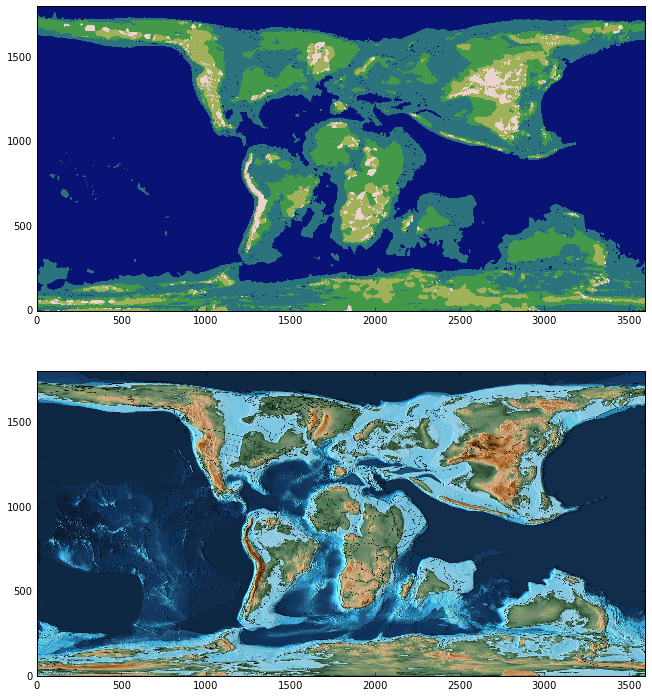

In [5]:
tmpp = inpaint.fill_ndimage(tmp)
#dind = find(~isnan(tmp));

# Make coordinates in world coordinates
# onto which to interpolate the grid height values
Xi = np.arange(-180,180,0.5)
Yi = np.arange(-90,90,0.5)

#gg = gridfit(Xg(dind),Yg(dind),tmp(dind),Xi,Yi);

plt.figure(figsize=(12,12))
plt.subplot(211)
plt.imshow(tmpp,vmin=np.min(ColorMapping[:,6])-300,vmax=np.max(ColorMapping[:,6])+300,
          aspect='equal',origin='lower',cmap=plt.cm.gist_earth)
plt.subplot(212)
plt.imshow(A,aspect='equal',origin='lower')
plt.show()


In [6]:
#file_list = glob.glob('/Users/Simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/PALEOMAP_PaleoAtlas_Rasters/*.jpg')
#
#raster_times = []
#for filename in file_list:
#    raster_age = filename[-7:-4]
#    print 'working on raster age %s' % raster_age
#
#    tmp,A = image2grid(filename,ColorMapping)
#    
#    tmpp = inpaint.fill_ndimage(tmp)
#    
#    plt.figure(figsize=(12,12))
#    plt.subplot(211)
#    plt.imshow(tmpp,vmin=np.min(ColorMapping[:,6]),vmax=np.max(ColorMapping[:,6]),
#              aspect='equal',origin='lower',cmap=plt.cm.gist_earth)
#    plt.subplot(212)
#    plt.imshow(A,aspect='equal',origin='lower')
#    plt.savefig('ScotesePaleotopography_%s.png' % raster_age)
#    plt.close()
#    
#    raster_times.append(raster_age)
    


### Make a plate frame representation of the images

The steps are:
- make a regularly spaced set of points on the sphere (TODO - switch to healpix mesh)
- partition these points into plates based on the PALEOMAP plate polygons (ie, no oceans included)
- 


In [56]:
import pygplates
import PyGPlates_PlateFrameRasters
import healpy as hp
from sphere_interp_kdtree import sampleOnSphere
from scipy.interpolate import RectBivariateSpline

input_rotation_filename = '/Users/Simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/PALEOMAP_Global_Plate_Model/PALEOMAP_PlateModel.rot'
static_polygons = '/Users/Simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/PALEOMAP_Global_Plate_Model/PALEOMAP_PlatePolygons.gpml'
rotation_model = pygplates.RotationModel(input_rotation_filename)


### Make a multipoint feature
### with points evenly distributed points on the sphere
nSide = 64
othetas,ophis = hp.pix2ang(nSide,np.arange(12*nSide**2))
othetas = np.pi/2-othetas
ophis[ophis>np.pi] -= np.pi*2
lats = np.degrees(othetas) 
lons = np.degrees(ophis)

num_points_whole_Earth = lons.shape[0]

multi_point_features = []
multi_point_feature = pygplates.Feature()
multi_point = pygplates.MultiPointOnSphere(zip(lats,lons))  
multi_point_feature.set_geometry(multi_point)
multi_point_features.append(multi_point_feature)


# Partitioning into points involves three steps:
# 1. make plate partitioner
plate_partitioner = pygplates.PlatePartitioner(static_polygons,
                                               rotation_model,
                                               reconstruction_time=0)

# 2. Apply plate partitioner to multipoint - get back one multipoint per polygon
pg_points = plate_partitioner.partition_features(multi_point_features,
                                                properties_to_copy = 
                                                 [pygplates.PartitionProperty.reconstruction_plate_id,
                                                  pygplates.PartitionProperty.valid_time_period])

# 3. Delete points with zero plateid
pg_points2 = []
for feature in pg_points:
    if feature.get_reconstruction_plate_id()!=0:
        pg_points2.append(feature)


# Loop over each image in the PALEOMAP data set
# First, get list of all image files in directory
file_list = glob.glob('/Users/Simon/Data/GPlates/PublishedModels/Scotese_PaleoAtlas/PALEOMAP_PaleoAtlas_Rasters/*.jpg')

time_list = []
flooded_continent_list = []

desamp = 5
Xrs = Xg[::desamp,::desamp]
Yrs = Yg[::desamp,::desamp]

# assume that the age is in the last 3 digits before the file extension
for filename in file_list:
    raster_age = filename[-7:-4]
    print 'working on raster age %s, rotation time = %0.2f' % (raster_age,dict[raster_age])

    # call the function to map the RGB values to height, and fill holes in image
    tmp,A = image2grid(filename,ColorMapping)
    tmpp = inpaint.fill_ndimage(tmp)
    
    # reconstruct the multipoint to the time for this image
    reconstructed_feature_geometries = []
    pygplates.reconstruct(pg_points2,
                          rotation_model,
                          reconstructed_feature_geometries,
                          reconstruction_time=float(raster_age))  # dict[raster_age]

    # interpolate values from image onto multipoint (warning - using flat Earth)
    f=RectBivariateSpline(X,Y,tmpp.T)

    # for each cookie-cut multipoint feature, we evaluate the image at the RECONSTRUCTED coordinates,
    # but then store the value at the PRESENT DAY coordinates (thus converting from reconstructed to 
    # plate frame of reference)
    rzvals = []
    for reconstructed_feature_geometry in reconstructed_feature_geometries:

        rlon,rlat,present_day_lat_lon = PyGPlates_PlateFrameRasters.GetReconstructedMultipoint(reconstructed_feature_geometry)
        num_points = len(rlon)

        gridZr = f.ev(rlon,rlat)
        for point_index in range(0, num_points):
            pdp = present_day_lat_lon[point_index]
            rzvals.append((pdp[1],pdp[0],gridZr[point_index]))

    rza = np.asarray(rzvals)
    

    print np.divide(float(np.where(rza[:,2]<0)[0].shape[0]),float(num_points_whole_Earth))

    make_figures = False
    if make_figures==True:
        plt.figure(figsize=(14,7))
        plt.scatter(rza[:,0],rza[:,1],c=rza[:,2],edgecolor='',s=4,cmap=plt.cm.gist_earth)
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.savefig('ScotesePaleotopographyPlateFrame_%s.png' % raster_age)
        plt.close()
       
    write_to_grid = True
    if write_to_grid==True:
        d,l = sampleOnSphere(rza[:,0],rza[:,1],rza[:,2],Xrs.flatten(),Yrs.flatten(),n=4)
        result = rza[:,2].ravel()[l]
        result = result.reshape(Xrs.shape)
        da = xr.DataArray(result,coords=[('lat',Y[::desamp]),('lon',X[::desamp])])
        ds = da.to_dataset('z')
        ds.to_netcdf('ScotesePaleotopographyPlateFrame_%s.nc' % raster_age)
    
    time_list.append(float(raster_age))
    flooded_continent_list.append(np.divide(float(np.where(rza[:,2]<0)[0].shape[0]),float(num_points_whole_Earth)))
    


working on raster age 000, rotation time = 0.00
0.735046386719
working on raster age 035, rotation time = 35.60
0.100382486979
working on raster age 040, rotation time = 38.80
0.120930989583
working on raster age 045, rotation time = 44.60
0.115661621094
working on raster age 050, rotation time = 52.20
0.154357910156
working on raster age 055, rotation time = 55.80
0.130716959635
working on raster age 060, rotation time = 60.60
0.123616536458
working on raster age 066, rotation time = 65.50
0.125752766927
working on raster age 070, rotation time = 68.00
0.130716959635
working on raster age 075, rotation time = 73.80
0.182169596354
working on raster age 080, rotation time = 80.30
0.187316894531
working on raster age 001, rotation time = 0.00
0.0934651692708
working on raster age 085, rotation time = 86.00
0.181518554688
working on raster age 090, rotation time = 91.10
0.16367594401
working on raster age 095, rotation time = 96.60
0.159138997396
working on raster age 100, rotation time =

/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:113: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument


In [12]:
dict = {'000':0,
       '001':0.00021,
       '004':3.7,
       '006':6.3,
       '010':10.5,
       '015':14.9,
       '020':19.5,
       '025':25.7,
       '030':31.1,
       '035':35.6,
       '040':38.8,
       '045':44.6,
       '050':52.2,
       '055':55.8,
       '060':60.6,
       '066':65.5,
       '070':68,
       '075':73.8,
       '080':80.3,
       '085':86,
       '090':91.1,
       '095':96.6,
       '100':101.8,
       '105':106,
       '110':110,
       '115':115.2,
       '120':121.8,
       '125':127.5,
       '130':132,
       '135':137,
       '140':143,
       '145':145.5,
       '150':148.2,
       '155':153.2,
       '160':158.4,
       '165':164.5,
       '170':169.7,
       '175':173.6,
       '180':179.3,
       '185':186.3,
       '190':189.6,
       '195':194.6,
       '200':199.6,
       '210':210,
       '220':222.6,
       '230':232.9,
       '240':241.5,
       '245':248.5,
       '250':251,
       '255':255.7,
       '260':263.1,
       '270':268.2,
       '275':273.1,
       '280':280,
       '290':290,
       '295':296.8,
       '300':301.2,
       '305':305.3,
       '310':309.5,
       '315':314.9,
       '320':323.2,
       '330':332.5,
       '340':341.1,
       '350':352.3,
       '360':359.2,
       '370':370.3,
       '380':379.9,
       '390':388.2,
       '395':394.3,
       '400':402.3,
       '410':409.1,
       '415':413.6,
       '420':419.5,
       '425':425.6,
       '430':432.1,
       '440':439.8,
       '445':444.7,
       '450':448.3,
       '460':456,    # something missing here?
       '470':473.4,
       '480':480,
       '490':488.3,
       '500':500,
       '510':510,
       '520':520,
       '530':533.5,
       '540':542,
       '600':600,
       '690':690,
       '750':750}

print dict['085']

86


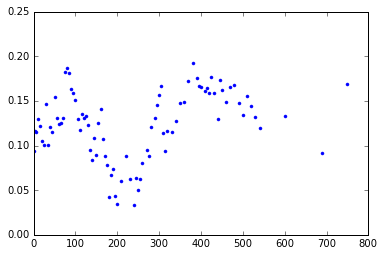

In [30]:
plt.plot(time_list,flooded_continent_list,'.')
plt.ylim(0,0.25)
plt.show()

         

(1800, 3600)


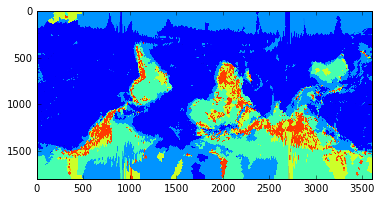

In [42]:
print result.reshape(Xrs.shape).shape
plt.imshow(result.reshape(Xrs.shape))
#plt.show()


In [52]:
import xarray as xr
da = xr.DataArray(result.reshape(Xg.shape),coords=[('lat',Y),('lon',X)])
ds = da.to_dataset('z')
ds.to_netcdf('test.nc')


/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  app.launch_new_instance()
